# Time Series Forecast: Emissions &rarr; Emissions (monthly resolution)

This script continues time series data for emissions. The current version gives a forecast for the next 6 months of emissions. For the current models there is no corona impact in the data. It can later be combined with the mapping function to predict the rest of the year.

Models:
    - SARIMA
    - MLP
    
Results can be seen on the plots displayed below.

For training, all availiable data for emissions are used, going back to 1990.

In [7]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
import random
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras import backend as K

## Read Data

In [8]:
# Read in emission data
emission_input = pd.read_csv('oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_input['Total_CO2_Emission'].values
emission_data = emission_data[0:len(emission_data)-6]
emission_data = emission_data.astype('float64')
emission_index = emission_input['date'].values
# Take only the emissions on which we have indicators
print(f"Shape output data: {emission_data.shape}")
#print(emission_index)


Shape output data: (366,)


In [9]:
data= pd.Series(emission_data)
first_date = emission_index[0]
last_date = emission_index[-1]
split_train = np.arange(0, len(data)-12)
split_test = np.arange((len(data)-12), len(data))
train_data = pd.Series(data, index=split_train)
test_data = pd.Series(data, index=split_test)
time_scope = emission_index

# Auto Sarima Model

In [10]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=710.594, BIC=729.768, Time=2.925 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=1385.064, BIC=1392.733, Time=0.058 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=750.042, BIC=765.382, Time=1.503 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=1057.452, BIC=1072.791, Time=1.288 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=1455.623, BIC=1459.458, Time=0.049 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=935.748, BIC=951.087, Time=0.232 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=685.687, BIC=708.696, Time=3.917 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=751.923, BIC=771.097, Time=1.901 seconds
Fit ARIMA(1,0,1)x(2,1,1,12) [intercept=True]; AIC=687.471, BIC=714.315, Time=10.344 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=687.465, BIC=714.309, Time=8.941 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  354
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -337.535
Date:                              Tue, 11 Aug 2020   AIC                            685.070
Time:                                      14:32:14   BIC                            704.244
Sample:                                           0   HQIC                           692.708
                                              - 354                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0430      0.030     -1.441      0.149      -0.101       0.015
ar.L1          0.9627      0.018     52.644      0.000       0.927       0.999
ar.S.L12      -0.3165      0.028    -11.379      0.000      -0.371      -0.262
ma.S.L12      -0.7349      0.034    -21.678      0.000      -0.801      -0.668
sigma2         0.4015      0.010     38.463      0.000       0.381       0.422
===================================================================================
Ljung-Box (Q):                       47.09   Jarque-Bera (JB):              8152.00
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.33
Prob(H) (two-sided):                  0.27   Kurtosis:                        26.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

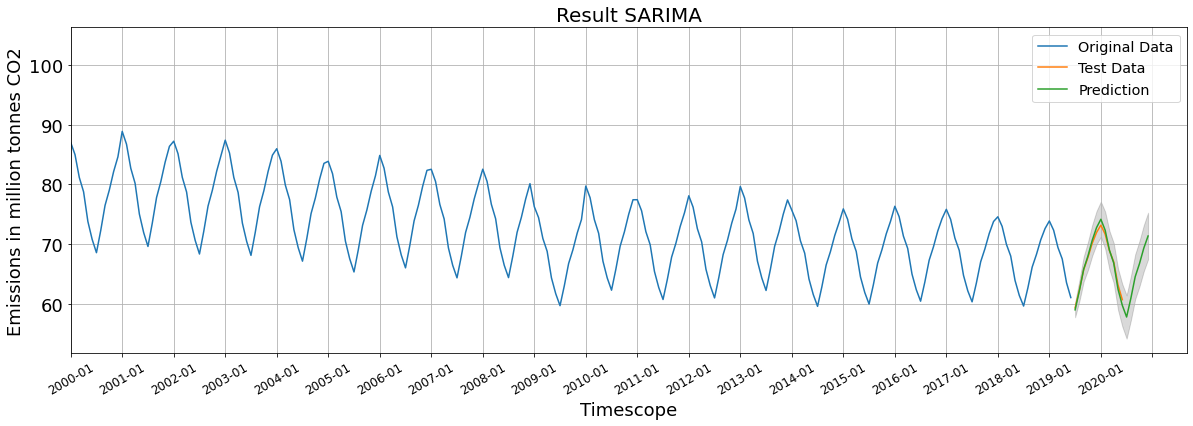

In [11]:
# Forecast
#to get accuracy predict last year as well
n_periods = 18
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
#index_of_fc = np.arange(len(data)-12, len(data)-12+n_periods)

index_of_fc = np.arange(len(data)-12, len(data)-12+n_periods)
index_of_test = np.arange(len(data)-12, len(data))
index_of_compare = np.arange(0,6)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
test_series = pd.Series(test_data, index=index_of_test)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
sarima_array = fitted[-7:-1]
sarima_compare = pd.Series(sarima_array, index=index_of_compare)

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(train_data, label='Original Data')
line3 = plt.plot(test_series, label='Test Data')
line2 = plt.plot(fitted_series, label='Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(len(time_scope)+1)[::12], time_scope[::12], rotation=30, fontsize=12)
#plt.xticks(np.arange(len(time_scope)), time_scope, rotation=30)
plt.xlim([120,380])
plt.xlabel("Timescope", fontsize=18)
plt.ylabel("Emissions in million tonnes CO2", fontsize=18)
plt.yticks(fontsize=18)
plt.title("Result SARIMA", fontsize=20)

plt.show()

In [12]:
# Accuracy metrics
fitted = fitted[0:12]
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    print("Accuracy of the model:")
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
forecast_accuracy(fitted, test_data)

Accuracy of the model:


{'mape': 0.007037505139794171,
 'me': 0.08894873886469057,
 'mae': 0.4726882483910882,
 'mpe': 0.000828340691553468,
 'rmse': 0.5740652353976862,
 'corr': 0.9986976708273446,
 'minmax': 0.00699944624918869}

## MLP Model

In [13]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
	dataX, dataY = [], []
	if len(input) != len(output):
		raise ValueError('Input and ouput do not have same length!')
	for i in range(len(input)-look_back-horizon):
		dataX.append(input[i:(i+look_back)])
		dataY.append(output[(i+look_back):(i+look_back+horizon)])
	# Shuffle windows
	if shuffle is True:
		dataX, dataY = shuffle(dataX, dataY, random_state=0)
	return np.array(dataX), np.array(dataY)

In [14]:
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [15]:
scaler = StandardScaler()
#emission_data = scaler.fit_transform(emission_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.8
shuffle = True

# Split into train and test sets
train_size = int(len(emission_data) * split_ratio)
test_size = len(emission_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

In [16]:
# Regressions forecast model with windowing method
def train_model(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
    model = Sequential()
    # Flatten array if input is matrix
    if len(trainX.shape) >= 3:
        model.add(Flatten())
        model.add(Dense(look_back, input_dim=trainX.shape[2]*look_back, activation='relu'))
    model.add(Dense(24, input_dim=look_back, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=[r2_keras])
    model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=2, callbacks=[es])
    model.summary()
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [17]:
# Emissions as input
trainX, trainY = sliding_window(emission_data[0:train_size],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(emission_data[train_size:len(emission_data)],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [18]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(274, 12)
(274, 6)
(56, 12)
(56, 6)


### Train Model

In [19]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Train model and generate predictions
model, trainPredict, testPredict = train_model(trainX, trainY, testX, testY, look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/100
137/137 - 0s - loss: 3373.5525
Epoch 2/100
137/137 - 0s - loss: 121.3547
Epoch 3/100
137/137 - 0s - loss: 41.4420
Epoch 4/100
137/137 - 0s - loss: 38.3738
Epoch 5/100
137/137 - 0s - loss: 34.3603
Epoch 6/100
137/137 - 0s - loss: 31.8664
Epoch 7/100
137/137 - 0s - loss: 28.6881
Epoch 8/100
137/137 - 0s - loss: 27.1275
Epoch 9/100
137/137 - 0s - loss: 25.1863
Epoch 10/100
137/137 - 0s - loss: 23.9712
Epoch 11/100
137/137 - 0s - loss: 22.9368
Epoch 12/100
137/137 - 0s - loss: 21.6907
Epoch 13/100
137/137 - 0s - loss: 21.0926
Epoch 14/100
137/137 - 0s - loss: 20.2190
Epoch 15/100
137/137 - 0s - loss: 19.9240
Epoch 16/100
137/137 - 0s - loss: 19.0748
Epoch 17/100
137/137 - 0s - loss: 18.7745
Epoch 18/100
137/137 - 0s - loss: 18.3966
Epoch 19/100
137/137 - 0s - loss: 18.1388
Epoch 20/100
137/137 - 0s - loss: 17.1663
Epoch 21/100
137/137 - 0s - loss: 17.0749
Epoch 22/100
137/137 - 0s - loss: 16.5427
Epoch 23/100
137/137 - 0s - loss: 16.1063
Epoch 24/100
137/137 - 0s - loss: 15.317

137/137 - 0s - loss: 4.6819
Epoch 53/100
137/137 - 0s - loss: 5.0582
Epoch 54/100
137/137 - 0s - loss: 4.7493
Epoch 55/100
137/137 - 0s - loss: 4.5011
Epoch 56/100
137/137 - 0s - loss: 4.4816
Epoch 57/100
137/137 - 0s - loss: 4.9372
Epoch 58/100
137/137 - 0s - loss: 5.1153
Epoch 59/100
137/137 - 0s - loss: 4.6129
Epoch 60/100
137/137 - 0s - loss: 4.6589
Epoch 61/100
137/137 - 0s - loss: 4.8570
Epoch 62/100
137/137 - 0s - loss: 4.6130
Epoch 63/100
137/137 - 0s - loss: 4.7378
Epoch 64/100
137/137 - 0s - loss: 4.6146
Epoch 65/100
137/137 - 0s - loss: 4.5435
Epoch 66/100
137/137 - 0s - loss: 4.3962
Epoch 67/100
137/137 - 0s - loss: 4.3322
Epoch 68/100
137/137 - 0s - loss: 4.6413
Epoch 69/100
137/137 - 0s - loss: 4.2551
Epoch 70/100
137/137 - 0s - loss: 4.4979
Epoch 71/100
137/137 - 0s - loss: 4.4461
Epoch 72/100
137/137 - 0s - loss: 4.7266
Epoch 73/100
137/137 - 0s - loss: 5.2752
Epoch 74/100
137/137 - 0s - loss: 4.2980
Epoch 75/100
137/137 - 0s - loss: 4.4061
Epoch 76/100
137/137 - 0s - l

Train Score: 3.80 MSE (1.95 RMSE)
Test Score: 1.71 MSE (1.31 RMSE)


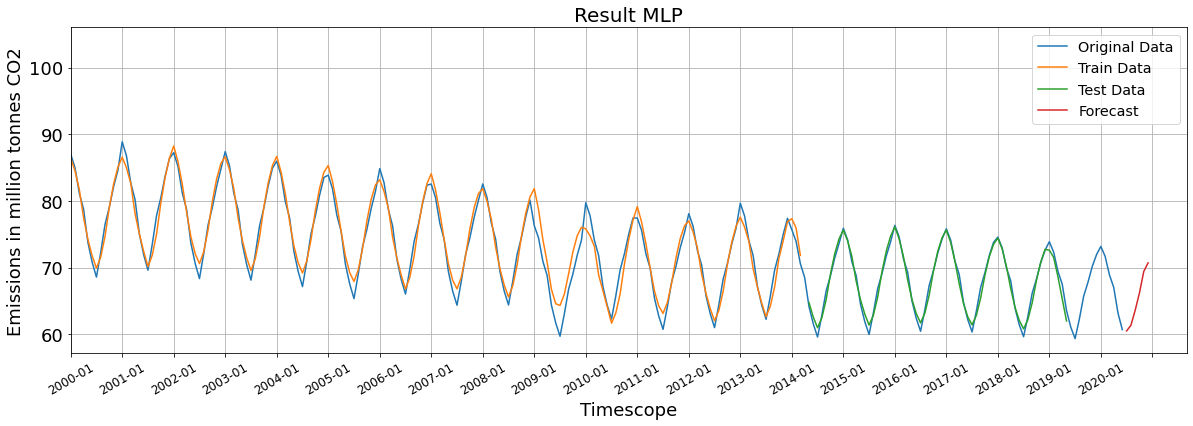

In [20]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan
mlp_compare = np.zeros(6)

X = np.zeros((1, look_back))
X[0] = emission_data[len(emission_data)-look_back:]
predict = model.predict(X)
forecastPlot[len(emission_data):len(emission_data)+horizon] = predict[:]
mlp_compare[0:6] = predict[:]

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(emission_data[:], label='Original Data')
line3 = plt.plot(trainPredictPlot[:], label='Train Data')
line2 = plt.plot(testPredictPlot[:], label='Test Data')
line4 = plt.plot(forecastPlot[:], label='Forecast')

plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(len(time_scope)+1)[::12], time_scope[::12], rotation=30, fontsize=12)
plt.xlim([120,380])
plt.xlabel("Timescope", fontsize=18)
plt.ylabel("Emissions in million tonnes CO2", fontsize=18)
plt.yticks(fontsize=18)
plt.title("Result MLP", fontsize=20)
plt.show()

#plt.xticks(np.arange(len(time_scope)), time_scope, rotation=30)


## Compare SARIMA with MLP

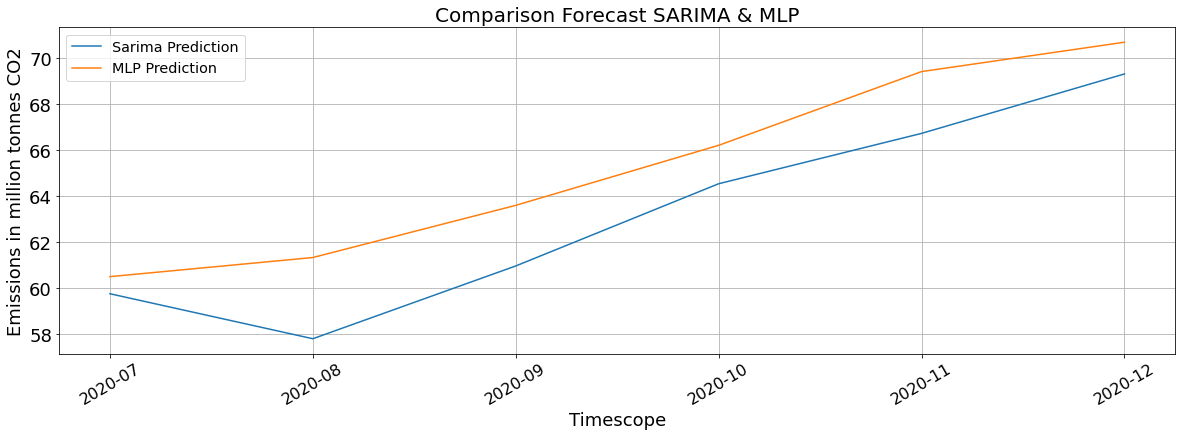

In [21]:
#sarima_plot = fitted[-7:-1]
#mlp_plot[0:horizon] = predict[:]
#sarima_plot = fitted_series[-7:-1] 


#plot difference between the forecasts
plt.figure(figsize=(20,6))
line1 = plt.plot(sarima_compare, label='Sarima Prediction')
line2 = plt.plot(mlp_compare, label='MLP Prediction')

plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(6), ['2020-07','2020-08', '2020-09', '2020-10', '2020-11', '2020-12'], rotation=30, fontsize=16)



plt.xlabel("Timescope", fontsize=18)
plt.ylabel("Emissions in million tonnes CO2", fontsize=18)
plt.yticks(fontsize=18)
plt.title("Comparison Forecast SARIMA & MLP", fontsize=20)
plt.show()


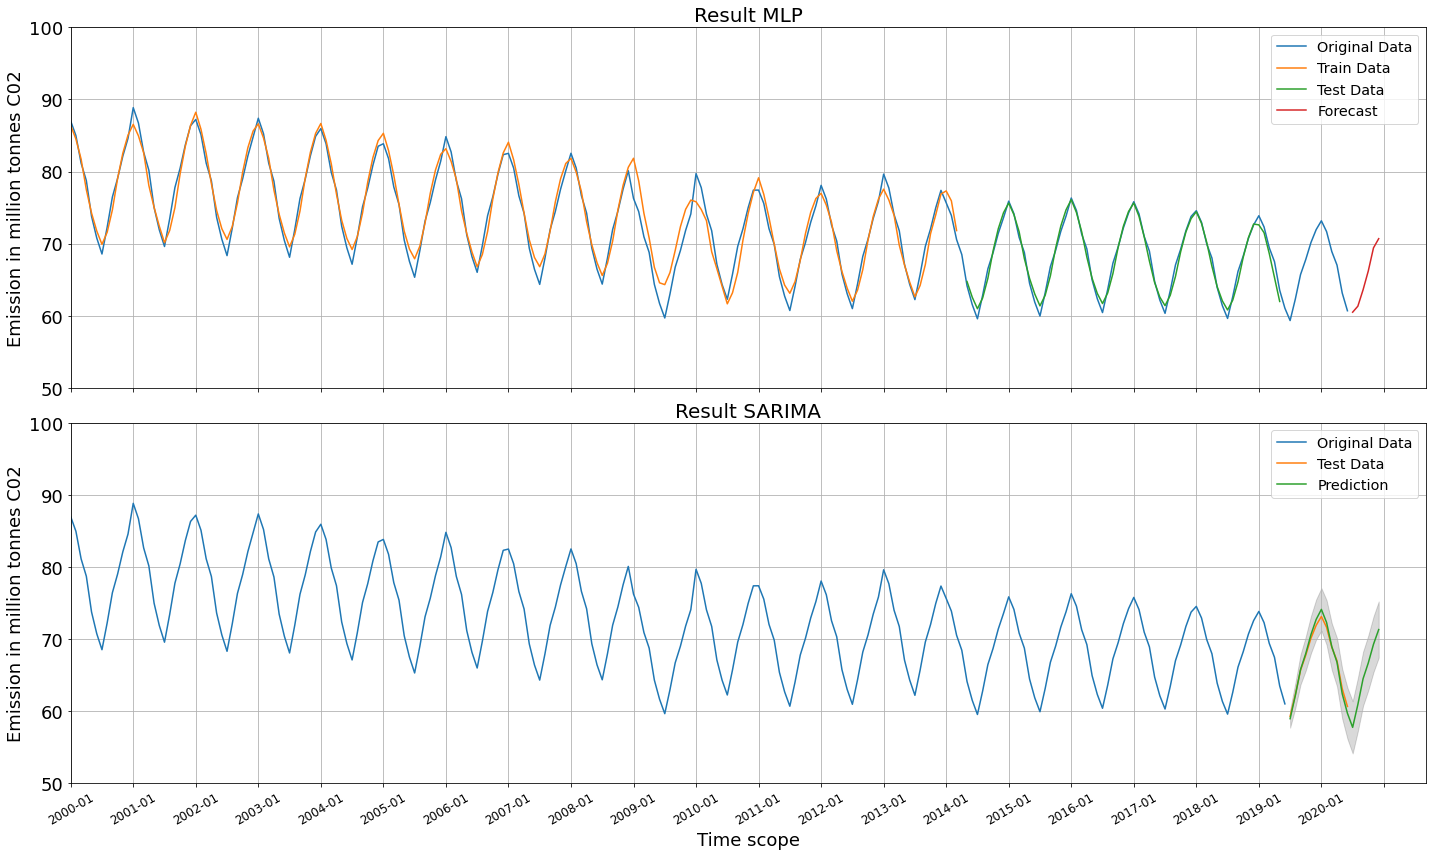

In [22]:
# Comparation between SARIMA and MLP, plots below each other
fig, ax = plt.subplots(2, figsize=(20,12), sharex=True)

# MLP
ax[0].plot(emission_data[:], label='Original Data')
ax[0].plot(trainPredictPlot[:], label='Train Data')
ax[0].plot(testPredictPlot[:], label='Test Data')
ax[0].plot(forecastPlot[:], label='Forecast')
ax[0].set_title('Result MLP', fontsize=20)
ax[0].set_ylabel('Emission in million tonnes C02', fontsize=18)
ax[0].yaxis.set_tick_params(labelsize=18)
ax[0].legend(fontsize='x-large', loc='upper right')
ax[0].grid()

# Sarima
ax[1].plot(train_data, label='Original Data')
ax[1].plot(test_series, label='Test Data')
ax[1].plot(fitted_series, label='Prediction')
ax[1].fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
ax[1].set_title('Result SARIMA', fontsize=20)
ax[1].set_ylabel('Emission in million tonnes C02', fontsize=18)
ax[1].yaxis.set_tick_params(labelsize=18)
ax[1].legend(fontsize='x-large', loc='upper right')
ax[1].grid()

plt.xticks(np.arange(len(time_scope)+1)[::12], time_scope[::12], rotation=30, fontsize=12)
plt.xlabel("Time scope", fontsize=18)
plt.tight_layout()
plt.xlim([120,380])
plt.setp(ax, ylim=[50,100])

plt.show()